# Groen, groener, groenst
Voor iedere buurt in Breda [EVI](https://en.wikipedia.org/wiki/Enhanced_vegetation_index)-data ophalen vanuit Earth Engine (blijkbaar iets heftiger dan NDVI), periode 2010 tot 2020, [MODIS](https://developers.google.com/earth-engine/datasets/catalog/MODIS_006_MOD13Q1), 250x250 meter.

In [1]:
import ee
import datetime
import geopandas as gpd
import pandas as pd
import numpy as np

In [2]:
def get_evi(start_date, end_date):
    '''to get evi data for breda, given start_date & end_date, returns image collection from start to end, filetered by aoi, only evi-band'''
    # init the ee object
    ee.Initialize()

    # define the area of interest
    breda = gpd.read_file('data/shape/breda.shp')
    breda = breda.to_crs(epsg=4326) # to lat-lon
    breda = breda.loc[0, 'geometry'].__geo_interface__
    AOI = ee.Geometry.Polygon(breda['coordinates'])

    # start - end date
    start_date = ee.Date(start_date)
    end_date = ee.Date(end_date)

    # return image collection
    return ee.ImageCollection('MODIS/006/MOD13Q1').filterDate(start_date, end_date).filterBounds(AOI).select('EVI')   

In [3]:
def to_dataframe(row):
    '''make dataframe containing mean evi for buurt, given row from geodataframe'''
    geometry = row['geometry'].__geo_interface__['coordinates'] # get coordinate list
    evibuurt = evi.getRegion(ee.Geometry.Polygon(geometry), 100).getInfo() # get points in geometry
    header = evibuurt[0]
    data = np.array(evibuurt[1:])

    time = [datetime.datetime.fromtimestamp(int(i)/1000) for i in data[0:,header.index('time')]] # convert timestamps
    values = data[0:,header.index('EVI')] # evi-values
    return pd.DataFrame(values, index=time, columns=[row['BU_NAAM']]).astype(float).resample('d').mean()

In [4]:
# load breda buurten
buurten = gpd.read_file('data/shape/breda_buurten.shp')
buurten = buurten.to_crs(epsg=4326) # to lat-lon

# get average EVI for each buurt in one dataframe cols -> buurt
data = pd.DataFrame()
for year in range(2000,2020): # split up in one year at a time, to not overload api
    print('{}-{} => 2020'.format(year, year + 1))
    # get ndvi for given period
    evi = get_evi(start_date='{}-01-01'.format(year), end_date='{}-01-01'.format(year + 1))

    cols = pd.DataFrame()
    for i, row in buurten.iterrows():
        df = to_dataframe(row)
        cols = pd.concat([cols, df], axis=1)
        print('{}/{}'.format(i+1, len(buurten)), end='\r')
    data = pd.concat([data, cols], axis=0)
data.to_csv('data/satdata/evi.csv')

2000-2001 => 2020
2001-2002 => 2020
2002-2003 => 2020
2003-2004 => 2020
2004-2005 => 2020
2005-2006 => 2020
2006-2007 => 2020
2007-2008 => 2020
2008-2009 => 2020
2009-2010 => 2020
2010-2011 => 2020
2011-2012 => 2020
2012-2013 => 2020
2013-2014 => 2020
2014-2015 => 2020
2015-2016 => 2020
2016-2017 => 2020
2017-2018 => 2020
2018-2019 => 2020
2019-2020 => 2020


In [5]:
data.groupby(data.index.year).describe()

Valkenberg                                                     \
          count         mean         std          min          25%   
2000       20.0  1685.626866  583.183501   858.477612  1112.910448   
2001       23.0  1560.016223  627.176065   340.119403  1139.343284   
2002       23.0  1654.604802  614.517378   642.179104  1120.350746   
2003       23.0  1577.485399  601.770568   760.910448  1070.567164   
2004       23.0  1659.489293  579.851521   613.104478  1176.119403   
2005       23.0  1726.636600  613.481289   748.895522  1253.402985   
2006       23.0  1609.850770  624.627349   447.328358  1013.522388   
2007       23.0  1644.098637  658.847807   512.194030  1094.820896   
2008       23.0  1708.875406  633.106773   882.149254  1055.828358   
2009       23.0  1581.460740  735.128341     4.985075  1040.544776   
2010       23.0  1499.279040  667.358580  -102.119403  1160.888060   
2011       23.0  1628.894873  542.997073   748.970149  1075.537313   
2012       23.0  1554.431611  718.486977   343.313433  1088.492537   
2013       23.0  1634.731992  556.011327   792.820896  1119.089552   
2014       23.0  1804.593770  678.600845    74.059701  1342.604478   
2015       23.0  1805.375081  574.772609   623.850746  1373.485075   
2016       23.0  1836.863725  555.977734  1041.791045  1311.059701   
2017       23.0  1703.558079  583.104316   655.044776  1251.022388   
2018       23.0  1719.959117  596.162640   730.283582  1167.186567   
2019       23.0  1846.741077  612.250192  1017.805970  1230.977612   

                                            ChassÃ©               ...  \
              50%          75%          max   count         mean  ...   
2000  1943.350746  2038.537313  2743.597015    20.0  1516.770968  ...   
2001  1348.835821  2056.059701  2720.746269    23.0  1337.647265  ...   
2002  1456.850746  2090.500000  2783.194030    23.0  1360.434783  ...   
2003  1476.089552  2093.134328  2691.582090    23.0  1298.026774  ...   
2004  1642.880597  2239.970149  2590.283582    23.0  1425.978261  ...   
2005  1678.567164  2156.514925  3096.000000    23.0  1458.134642  ...   
2006  1762.074627  2083.828358  2657.298507    23.0  1334.710238  ...   
2007  1597.447761  2214.134328  2687.507463    23.0  1605.859748  ...   
2008  1756.970149  2244.432836  2880.268657    23.0  1709.029453  ...   
2009  1742.567164  2111.686567  2696.313433    23.0  1542.034362  ...   
2010  1468.850746  2032.537313  2390.582090    23.0  1439.440393  ...   
2011  1773.686567  2098.358209  2358.134328    23.0  1654.285414  ...   
2012  1328.611940  2179.470149  2909.104478    23.0  1564.392707  ...   
2013  1693.089552  2100.723881  2505.134328    23.0  1569.974879  ...   
2014  1928.537313  2358.611940  2919.059701    23.0  1739.323983  ...   
2015  1675.582090  2319.343284  2674.522388    23.0  1792.147966  ...   
2016  1872.701493  2155.089552  2880.343284    23.0  1831.122721  ...   
2017  1778.805970  2153.611940  2744.119403    23.0  1746.945302  ...   
2018  1775.238806  2135.940299  2834.880597    23.0  1669.055400  ...   
2019  1983.119403  2452.873134  2631.223881    23.0  1762.464236  ...   

      Vuchtpolder              Buitengebied Teteringen               \
              75%          max                   count         mean   
2000  5476.594360  6151.572668                    20.0  3776.755991   
2001  5002.500939  6274.183297                    23.0  3637.119606   
2002  5611.620390  6338.545553                    23.0  3836.272858   
2003  4875.188720  5969.663774                    23.0  3475.046543   
2004  5475.297180  6331.404580                    23.0  3673.782208   
2005  5149.045553  6237.874187                    23.0  3691.594506   
2006  5444.104121  6181.301518                    23.0  3569.960041   
2007  5512.162690  6344.633406                    23.0  3492.656283   
2008  5377.729393  6408.496746                    23.0  3630.451811   
2009  5666.723970  6459.011931                    23.0  3613.722102   
2010 

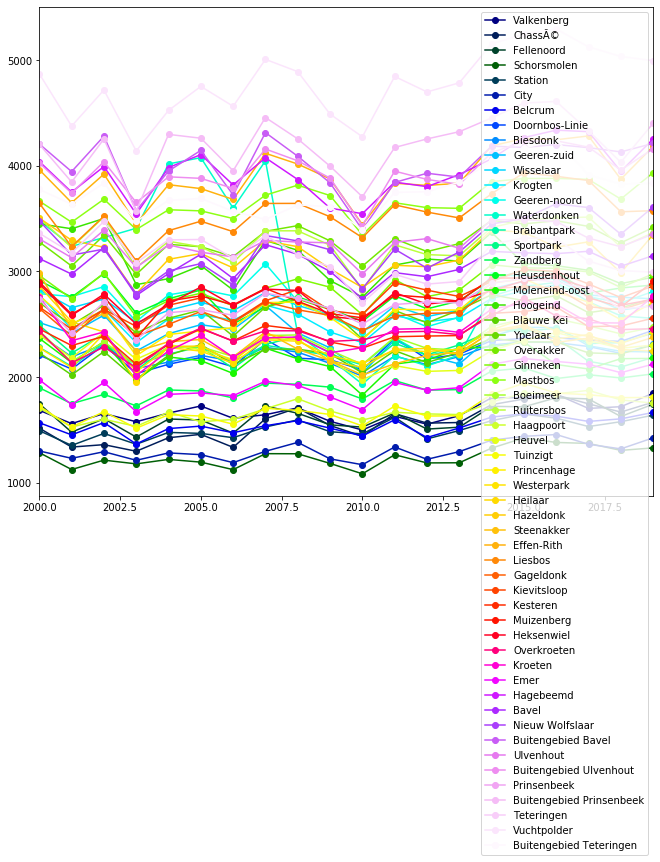

In [6]:
data.groupby(data.index.year).mean().plot(figsize=(11,9), style='-o', cmap='gist_ncar')

2000          AxesSubplot(0.1,0.77069;0.173913x0.12931)
2001     AxesSubplot(0.308696,0.77069;0.173913x0.12931)
2002     AxesSubplot(0.517391,0.77069;0.173913x0.12931)
2003     AxesSubplot(0.726087,0.77069;0.173913x0.12931)
2004         AxesSubplot(0.1,0.615517;0.173913x0.12931)
2005    AxesSubplot(0.308696,0.615517;0.173913x0.12931)
2006    AxesSubplot(0.517391,0.615517;0.173913x0.12931)
2007    AxesSubplot(0.726087,0.615517;0.173913x0.12931)
2008         AxesSubplot(0.1,0.460345;0.173913x0.12931)
2009    AxesSubplot(0.308696,0.460345;0.173913x0.12931)
2010    AxesSubplot(0.517391,0.460345;0.173913x0.12931)
2011    AxesSubplot(0.726087,0.460345;0.173913x0.12931)
2012         AxesSubplot(0.1,0.305172;0.173913x0.12931)
2013    AxesSubplot(0.308696,0.305172;0.173913x0.12931)
2014    AxesSubplot(0.517391,0.305172;0.173913x0.12931)
2015    AxesSubplot(0.726087,0.305172;0.173913x0.12931)
2016             AxesSubplot(0.1,0.15;0.173913x0.12931)
2017        AxesSubplot(0.308696,0.15;0.173913x0

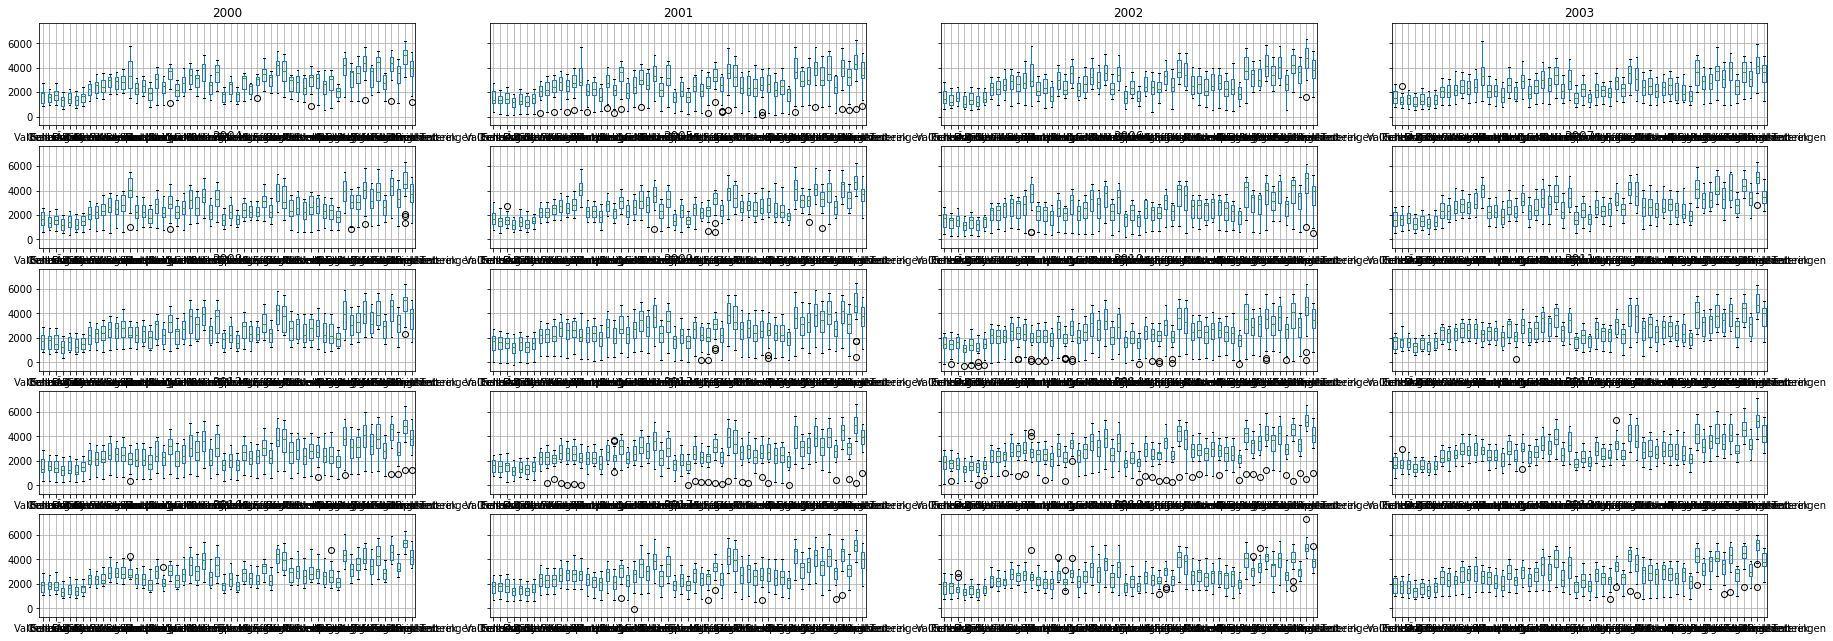

In [7]:
data.groupby(data.index.year).boxplot(figsize=(30,11))

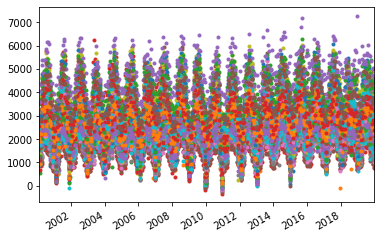

In [10]:
data.plot(legend=False, style='.')